## COMP3670/6670 Programming Assignment 3 - Linear Regression ##
---

**Enter Your Student ID:**

**Your Name:**
    
**Deadline:** 

**Submit:** Write your answers in this file, and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Note: you don't need to submit the .png or .npy files. 

**Enter Discussion Partner IDs Below:**
You could add more IDs with the same markdown format above.
Please implement things by yourself. If you use any external resources, list them here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The following section provides some helper functions.

In [2]:
## GENERAL FUNCTIONS - DO NOT MODIFY ##
def lr_mle(X, y):
    # maximum likelihood (least squares) for linear regression 
    XtX = np.dot(X.T, X)
    Xty = np.dot(X.T, y)
    theta = np.linalg.solve(XtX, Xty)
    return theta

def lr_map(X, y, alpha=0.1):
    # maximum a-posteriori (regularised least squares) for linear regression
    N, D = X.shape[0], X.shape[1]
    XtX = np.dot(X.T, X) + np.diag(alpha*N*np.ones(D))
    Xty = np.dot(X.T, y)
    theta = np.linalg.solve(XtX, Xty)
    return theta

def lr_bayes(X, y, alpha=0.1, noise_var=0.01):
    # exact posterior for Bayesian linear regression
    N, D = X.shape[0], X.shape[1]
    XtX = np.dot(X.T, X) + np.diag(alpha*N*np.ones(D))
    Xty = np.dot(X.T, y)
    mean = np.linalg.solve(XtX, Xty)
    # note: calling inv directly is not ideal
    cov = np.linalg.inv(XtX) * noise_var
    return mean, cov

def predict_point(X, theta):
    # predict given parameter estimate
    return np.dot(X, theta)

def predict_bayes(X, theta_mean, theta_cov):
    # predict gien parameter posterior
    mean = np.dot(X, theta_mean)
    cov = np.dot(X, np.dot(theta_cov, X.T))
    return mean, cov

def add_bias_col(x):
    # add an all-one column
    n = x.shape[0]
    return np.hstack([x, np.ones([n, 1])])

## END GENERAL FUNCTIONS ##

### **Task 0: Warming Up** ###

The following code block visualises the difference between different methods of performing linear regression. 

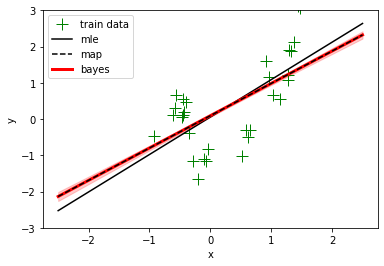

In [3]:
# load data
data = np.loadtxt("./data/ass3_data1_train.txt")
x_train, y_train = data[:, 0][:, None], data[:, 1][:, None]
data = np.loadtxt("./data/ass3_data1_valid.txt")
x_valid, y_valid = data[:, 0][:, None], data[:, 1][:, None]

# some data for visualisation
N_plot = 100
x_plot = np.linspace(-2.5, 2.5, N_plot).reshape([N_plot, 1])

# add one col to the inputs
x_train_with_bias = add_bias_col(x_train)
x_plot_with_bias = add_bias_col(x_plot)

# MLE = least squares
theta_mle = lr_mle(x_train_with_bias, y_train)
f_mle = predict_point(x_plot_with_bias, theta_mle)

# MAP = regularised least squares
alpha = 0.1
theta_map = lr_map(x_train_with_bias, y_train, alpha)
f_map = predict_point(x_plot_with_bias, theta_map)

# exact Bayesian
theta_mean, theta_cov = lr_bayes(x_train_with_bias, y_train, alpha)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_with_bias, theta_mean, theta_cov)

# plot utility
def plot(x, y, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov):
    # plot utility
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, '+g', label='train data', ms=12)
    if f_mle is not None:
        plt.plot(x_plot, f_mle, '-k', label='mle')
    if f_map is not None:
        plt.plot(x_plot, f_map, '--k', label="map", zorder=10)
    if f_bayes_mean is not None:
        plt.plot(x_plot, f_bayes_mean, '-r', label="bayes", lw=3)
        f_std = np.sqrt(np.diag(f_bayes_cov))
        upper = f_bayes_mean[:, 0] + 2*f_std
        lower = f_bayes_mean[:, 0] - 2*f_std
        plt.fill_between(x_plot[:, 0], upper, lower, color='r', alpha=0.2)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-3, 3])

# plot the training data and predictions
plot(x_train, y_train, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov)

### **Task 1: What makes a good regression?** ###

As can be seen from the visualisation above, the regressed line seems to be far from the datapoints. Are there any ways we can improve the regression?

1.1: The feature is linear while the data is not

1.2: polynomial/sin/cosine features, as the data is showing a non-linear and oscillating trend.

**Task1.3**

Implement `featurise` function that takes raw datapoints as the input and output a reasonable design matrix $\Phi$ according to the method you mentioned in **Task 1.2**.

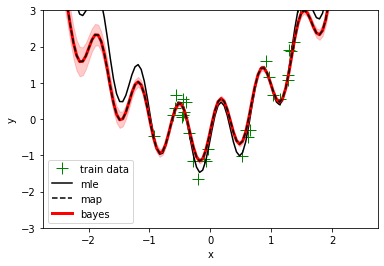

In [4]:
def featurise(x):
    D = 3
    N = x.shape[0]
    x_new = np.ones([N, 1])
    for d in range(D-1):
        x_new = np.hstack([x_new, x**(d+1)])
    x_new = np.hstack([x_new, np.sin(3*np.pi*x)])
    return x_new

x_train_feat = featurise(x_train)
x_valid_feat = featurise(x_valid)
x_plot_feat = featurise(x_plot) 

# repeat but now with features
# MLE
theta_mle = lr_mle(x_train_feat, y_train)
f_mle = predict_point(x_plot_feat, theta_mle)

# MAP
alpha = 0.1
theta_map = lr_map(x_train_feat, y_train, alpha)
f_map = predict_point(x_plot_feat, theta_map)

# exact Bayesian
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)

plot(x_train, y_train, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov)

### **Task 2: Estimating noise variance through the marginal likelihood** ###

One commonly asked question in Bayesian linear regression is how can we define the noise level of the target. In previous questions, we set the noise variance in `lr_bayes` to be 0.01 - a fixed constant. But intuitively, after we have observed some datapoints, the noise level can actually be inferred or estimated. This tasks is designed for you to investigate the marginal likelihood (a.k.a. model evidence) and how we can use this to pick the noise variance. 

**Task 2.1**

Implement the negative log marginal likelihood, given the noise level of the likelihood, training inputs and outputs, and the prior variance. We can pick `prior_var` using the same procedure, but assume `prior_var = 0.5` for this exercise. The form of the marginal likelihood is provided in Week 7's lecture slides.

In [6]:
# 2a
def negative_log_marginal_likelihood(noise_var, x, y, prior_var=0.5):
    N = x.shape[0]
    m = np.zeros_like(y)
    s = prior_var * np.dot(x, x.T) + noise_var * np.eye(N)
    from scipy.stats import multivariate_normal
    res = -multivariate_normal.logpdf(y[:, 0], mean=m[:, 0], cov=s)
    return res

**Task 2.2**

Select the most appropriate noise level that minimises the log marginal likelihood. In practice, we can do this mimimisation by gradient descent, but for this exercise, we assume we have access to a predefined set of potential noise levels and just need to pick one.




In [7]:
# 2.2
# a predefined list
potential_noise_vars = np.logspace(-4, 1.5, 50)

## YOUR CODE HERE! ##
nlmls = [negative_log_marginal_likelihood(noise_var, x_train_feat, y_train) for noise_var in potential_noise_vars]
noise_var_estimated = potential_noise_vars[np.argmin(nlmls)]
#####################

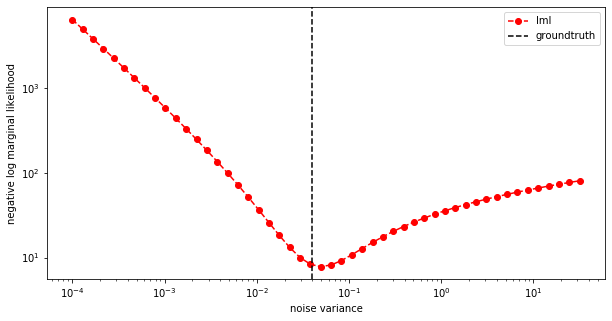

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(potential_noise_vars, nlmls, 'o--r', label='lml')
ax.axvline(0.04, linestyle='--', color='k', label='groundtruth')
ax.legend()
ax.set_xlabel('noise variance')
ax.set_ylabel('negative log marginal likelihood')
ax.set_xscale('log')
ax.set_yscale('symlog')

**Task 2.3**

We visualise the predictions using the estimated noise variance, and compare to those when the noise is very large or very small. Based on these graphs and the negative log marginal likelihood corresponding to these noise levels, explain why finding a proper noise level of the likelihood is important. 

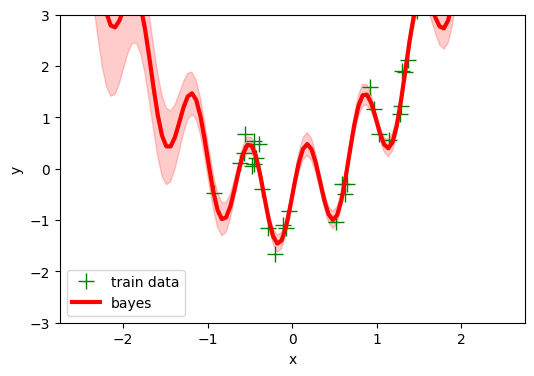

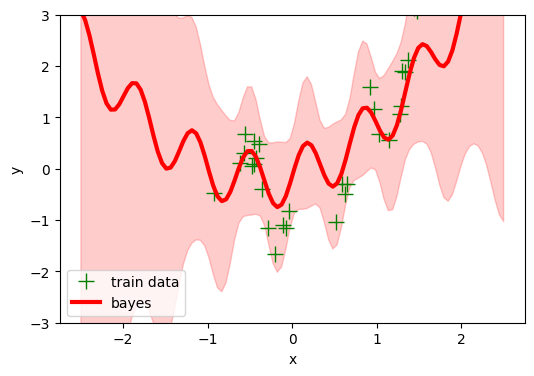

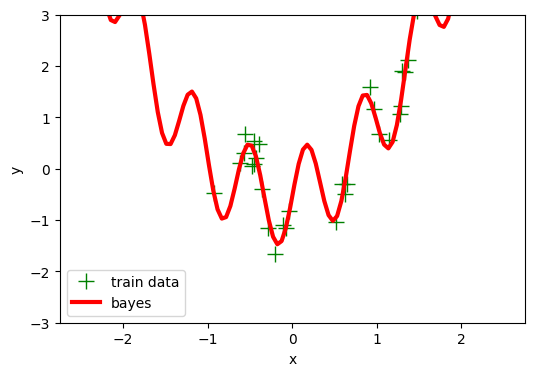

In [7]:
# fit with the estimated noise variance
N = x_train_feat.shape[0]
prior_var = 0.5
alpha = noise_var_estimated / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var_estimated)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

# fit with a very large noise
noise_var = 5
alpha = noise_var / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

# fit with a very small noise
noise_var = 0.00001
alpha = noise_var / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

Too small variance ignores uncertainty and gives away robustness, while too large variance makes the model not "confident", reducing the predictability in unseen areas. (Any other things reasonable are also fine) 

** Task 2.4 - Optional **

The naive implementation of the negative log marginal likelihood above would require the inverse of an N by N matrix, which is of time complexity $\Theta(N^3)$. This is computationally intractable for a large dataset (large N). Can we speed this up?

In [9]:
data = np.loadtxt("./data/ass3_data1_train_large.txt")
x_large, y_large = data[:, 0][:, None], data[:, 1][:, None]
x_large_feat = featurise(x_large)

def negative_log_marginal_likelihood_v2(noise_var, x, y, prior_var=0.5):
    # TODO: implement this
    return 0

### **Task 3: Regularisation** ###

In machine learning, regularisation is an important technique to reduce overfitting. Regularisation also provides better generalisation in general. This task aims to show how regularisation affects the parameter estimates. 

**Task 3.1**

Implement `L1`, `L2`. Both functions take the weight $\theta$ as input, output the regularisation value and the gradient of the regularisation term (**NOT THE GRADIENT OF THE ENTIRE OBJECTIVE FUNCTION**).

In [10]:
def L1(theta):
    res = np.sum(np.abs(theta))
    return res, np.sign(theta)

def L2(theta):
    # implement this
    l2 = np.sum(theta**2)
    grad = 2 * theta
    return l2, grad

def data_fit(theta, x, y):
    diff = y - np.dot(x, theta) # N x 1
    f = np.mean(diff**2) # 1 x 1
    df = - 2 * np.dot(diff.T, x).T / x.shape[0]
    return f, df 

def objective(theta, x, y, alpha, l2=True):
    reg_func = L2 if l2 else L1
    reg, dreg = reg_func(theta)
    fit, dfit = data_fit(theta, x, y)
    obj = fit + alpha * reg
    dobj = dfit + alpha * dreg
    return obj, dobj

**Task 3.2**

We now run gradient descent and plot the predictions. Comment on the results.

0 6.370877814124492
100 0.23552883464540544
200 0.23538199931958542
300 0.2353818263698137
400 0.2353818261661041
500 0.23538182616586414
600 0.2353818261658639
700 0.23538182616586384
800 0.23538182616586384
900 0.23538182616586387
1000 0.23538182616586384
1100 0.2353818261658639
1200 0.2353818261658639
1300 0.2353818261658639
1400 0.2353818261658639
1500 0.2353818261658639
1600 0.2353818261658639
1700 0.2353818261658639
1800 0.2353818261658639
1900 0.2353818261658639
0 0.31505003307567064
100 0.31066356532645073
200 0.3105347727882402
300 0.3105256651515904
400 0.3105250210998671
500 0.31052497555538205
600 0.31052497233467774
700 0.3105249721069238
800 0.3105249720908181
900 0.3105249720896791
1000 0.3105249720895986
1100 0.3105249720895929
1200 0.3105249720895925
1300 0.3105249720895925
1400 0.31052497208959245
1500 0.3105249720895925
1600 0.31052497208959245
1700 0.31052497208959245
1800 0.3105249720895925
1900 0.31052497208959245
0 0.06529669491062395
100 0.04347955841908003
200 

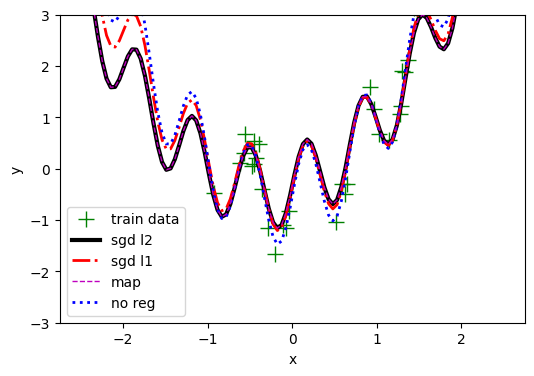

In [11]:
D = x_train_feat.shape[1]
theta_l2_sgd_init = np.random.randn(D, 1)
theta_l2_sgd = theta_l2_sgd_init

no_iters = 2000
learning_rate = 0.1
alpha = 0.1
l2 = True
for i in range(no_iters):
    obj, dobj = objective(theta_l2_sgd, x_train_feat, y_train, alpha, l2)
    theta_l2_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)

f_l2_sgd = predict_point(x_plot_feat, theta_l2_sgd)

theta_l1_sgd = theta_l2_sgd_init
l2 = False
for i in range(no_iters):
    obj, dobj = objective(theta_l1_sgd, x_train_feat, y_train, alpha, l2)
    theta_l2_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)
f_l1_sgd = predict_point(x_plot_feat, theta_l1_sgd)

# Without any regularisation
theta_noreg_sgd = theta_l2_sgd_init
for i in range(no_iters):
    obj, dobj = objective(theta_noreg_sgd, x_train_feat, y_train, 0, l2)
    theta_noreg_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)

f_noreg_sgd = predict_point(x_plot_feat, theta_noreg_sgd)

theta_map = lr_map(x_train_feat, y_train, alpha)
f_map = predict_point(x_plot_feat, theta_map)

# plot utility
plt.figure(figsize=(6, 4))
plt.plot(x_train, y_train, '+g', label='train data', ms=12)
plt.plot(x_plot, f_l2_sgd, '-k', lw=3, label='sgd l2')
plt.plot(x_plot, f_l1_sgd, '-.r', lw=2, label='sgd l1')
plt.plot(x_plot, f_map, '--m', label="map", zorder=10, lw=1)
plt.plot(x_plot, f_noreg_sgd, ':b', label="no reg", lw=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-3, 3])

plt.show()

At least two reasonable comparisons here.